# Определение возраста покупателей

В ходе выполнения этой работы перед нами поставлены следующие задачи:

1) Подготовить отчёт по исследованию данных 

2) Обучить модель, которая поможет определять возраст по фотографии

Условие. Метрика MAE должа быть не выше 8.

## Исследовательский анализ данных

Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import  Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
RANDOM_STATE=12345

Загрузка файла

In [3]:
%%time

data = pd.read_csv('/datasets/faces/labels.csv')
preview_datagen = ImageDataGenerator(rescale=1./255)
preview_gen_flow = preview_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.
CPU times: user 561 ms, sys: 480 ms, total: 1.04 s
Wall time: 1min 26s


Первичное ознакомлеие с данными

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
data.shape

(7591, 2)

In [6]:
data.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [7]:
display(data.describe(include= 'all'))

,file_name,real_age
count,7591,7591.000000
unique,7591,NaN
top,000033.jpg,NaN
freq,1,NaN
mean,NaN,31.201159
std,NaN,17.145060
min,NaN,1.000000
25%,NaN,20.000000
50%,NaN,29.000000
75%,NaN,41.000000


Рассмотрим на графиках наиболее часто встечающиеся возрасты

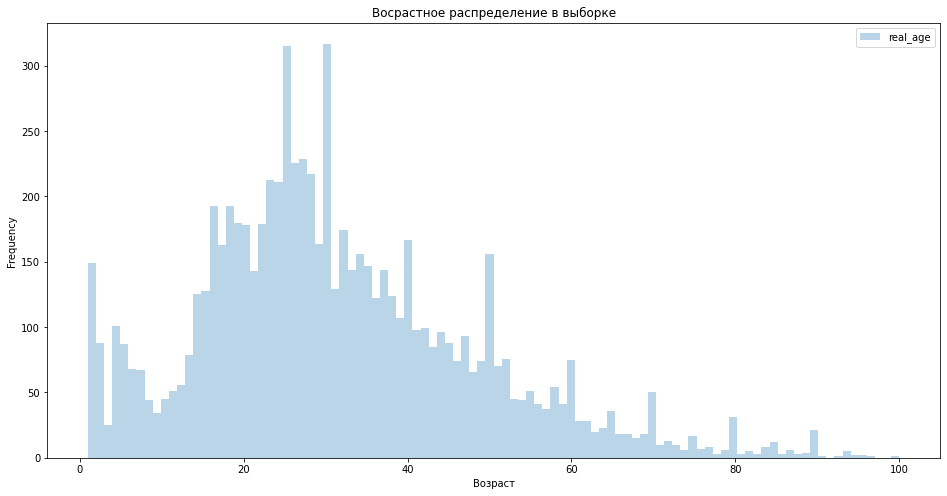

In [8]:
fig, ax = plt.subplots()
ax.set_title('Восрастное распределение в выборке')
ax.set_xlabel('Возраст')
data.plot(kind='hist', bins=100, figsize=(16,8), ax=ax, alpha=0.3);

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


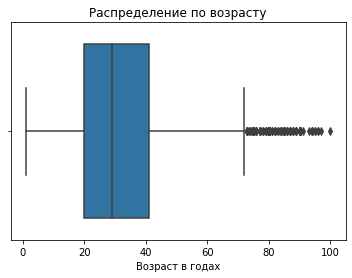

In [9]:
sns.boxplot(data['real_age'])
plt.title('Распределение по возрасту')
plt.xlabel('Возраст в годах')
plt.show()

In [10]:
#features, target = next(preview_gen_flow)

#fig=plt.figure(figsize=(10,10))

#for i in range(15):
#    fig.add_subplot(4, 4, i+1)
#    plt.imshow(features[i])
    
#    plt.xticks([])
#    plt.yticks([])
#    plt.tight_layout()

In [11]:
display(data.shape)
test = data.sample(frac = 0.2, random_state=12345)
display(test.shape)
test_index = test.index
data = data.query('index not in @test_index')
valid = data.sample(frac = 0.25, random_state=12345)
display(valid.shape)
valid_index = valid.index
dataframe = data.query('index not in @valid_index')
display(data.shape)

(7591, 2)

(1518, 2)

(1518, 2)

(6073, 2)

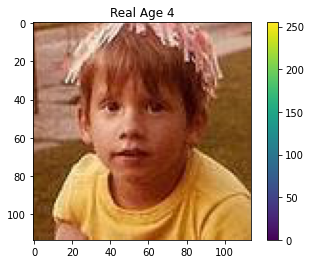

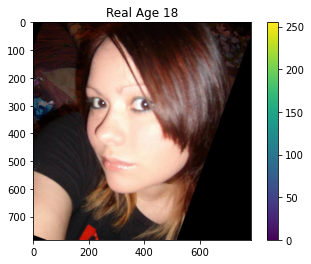

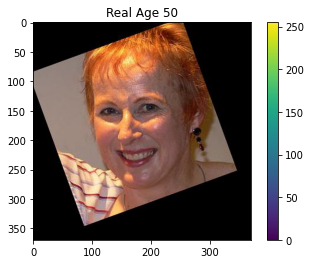

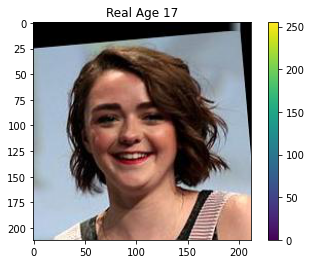

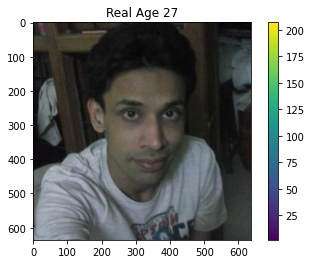

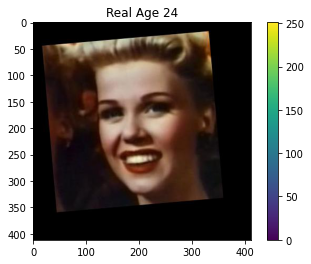

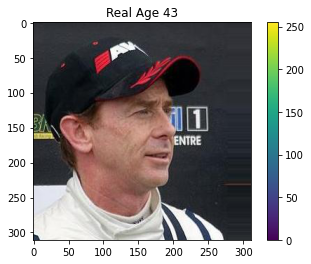

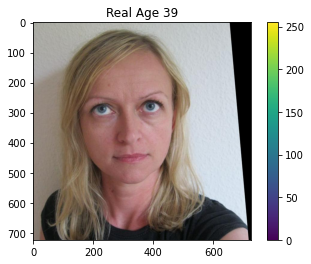

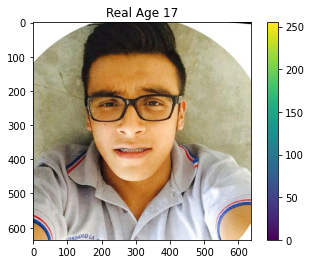

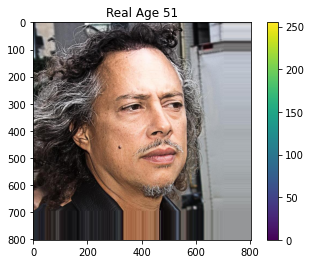

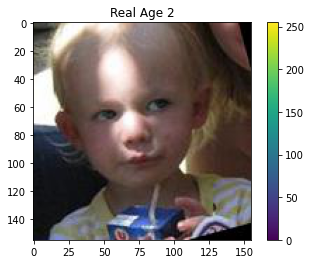

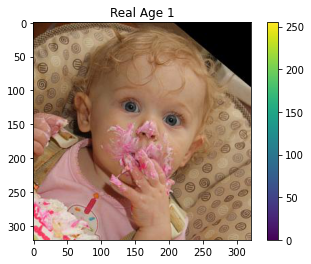

In [12]:
for i, k in zip(data.file_name[:12],data.real_age[:12]):
    image = Image.open('/datasets/faces/final_files/'+i)
    array = np.array(image)
    plt.imshow(array)
    plt.title('Real Age {:.0f}'.format(k))
    plt.colorbar()
    plt.show()

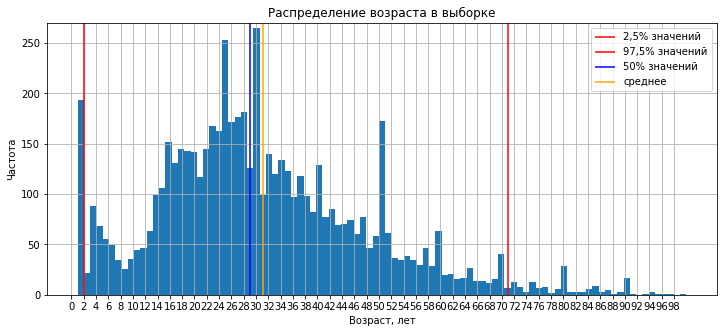

In [13]:
data['real_age'].hist(bins = len(data['real_age'].unique()),
                     figsize = (12,5))
plt.vlines(
    x = data['real_age'].quantile(0.025),
    ymin = 0,
    ymax = data['real_age'].value_counts().max()+5,
    colors = 'r',
    label = '2,5% значений'
)

plt.vlines(
    x = data['real_age'].quantile(0.975),
    ymin = 0,
    ymax = data['real_age'].value_counts().max()+5,
    colors = 'r',
    label = '97,5% значений'
)

plt.vlines(
    x = data['real_age'].quantile(0.5),
    ymin = 0,
    ymax = data['real_age'].value_counts().max()+5,
    colors = 'b',
    label = '50% значений'
)

plt.vlines(
    x = data['real_age'].mean(),
    ymin = 0,
    ymax = data['real_age'].value_counts().max()+5,
    colors = 'orange',
    label = 'среднее'
)

plt.title('Распределение возраста в выборке')
plt.ylim(top = data['real_age'].value_counts().max()+5)
plt.legend()
plt.ylabel('Частота')
plt.xticks(range(0, data['real_age'].max(), 2))
plt.xlabel('Возраст, лет')
plt.show()

**Вывод:** 

Мы открыли файл и импортировали библиотеки и обнаружили 7591 уникальных изображений и размером 224x224. Это достаточно, чтобы не использоватьзаморозку данных, чтобы избежать переобучения модели. Подавляющее число фотографий выполнено в нормальном цветовом спектре

Распределение графика похоже на Распределение Пуассона со средним значением 31,2 и стандартным отклонением 17,2, а большая часть значений - 95% лежит в диапазоне от 2 лет до 71 года. Есть предположение, почему группы людей старше 71 года так мало представлены, поскольку есть вероятность, что нейросеть не совсем точно сможет определить возраст старшего поколения.

## Обучение модели

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

2023-09-07 19:10:24.881886: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-09-07 19:10:24.883551: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-09-07 19:10:25.738776: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-09-07 19:10:25.747811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-09-07 19:10:25.747867: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-09-07 19:10:25.747898: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-07 19:10:25.749958: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-09-07 19:10:25.750301: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-09-07 19:10:25.752239: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-09-07 19:10:25.753367: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-09-07 19:10:25.753424: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-09-07 19:10:25.756017: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-09-07 19:10:25.930257: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-09-07 19:10:25.936894: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-09-07 19:10:25.937519: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5a2a050 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-07 19:10:25.937545: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-09-07 19:10:26.103295: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5907cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-07 19:10:26.103330: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-09-07 19:10:26.104975: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-09-07 19:10:26.105047: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-09-07 19:10:26.105062: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-07 19:10:26.105098: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-09-07 19:10:26.105115: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-09-07 19:10:26.105130: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-09-07 19:10:26.105144: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-09-07 19:10:26.105156: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-09-07 19:10:26.108375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-09-07 19:10:26.108445: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-09-07 19:10:26.463894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-09-07 19:10:26.463948: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-09-07 19:10:26.463959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-09-07 19:10:26.467887: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-09-07 19:10:26.467947: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 16s
  253952/94765736 [..............................] - ETA: 19s
 1220608/94765736 [..............................] - ETA: 7s 
 6160384/94765736 [>.............................] - ETA: 2s
13049856/94765736 [===>..........................] - ETA: 1s
20619264/94765736 [=====>........................] - ETA: 0s
27623424/94765736 [=======>......................] - ETA: 0s
35299328/94765736 [==========>...................] - ETA: 0s
42901504/94765736 [============>.................] - ETA: 0s
50192384/94765736 [==============>...............] - ETA: 0s
57925632/94765736 [=================>............] - ETA: 0s
65658880/94765736 [===================>..........] - ETA: 0s
73097216/94765736 [======================>.......] - ETA: 0s
80674816/94765736 [========================>.....] - ETA: 0s
88170496/94765736 [==========================>...] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-09-07 19:10:38.038494: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-07 19:10:38.341548: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 52s - loss: 208.0657 - mae: 10.4173 - val_loss: 307.7602 - val_mae: 13.1054
Epoch 2/10
356/356 - 41s - loss: 82.3694 - mae: 6.9249 - val_loss: 110.9266 - val_mae: 8.0161
Epoch 3/10
356/356 - 45s - loss: 56.0367 - mae: 5.7471 - val_loss: 100.4793 - val_mae: 7.5640
Epoch 4/10
356/356 - 41s - loss: 40.9695 - mae: 4.9273 - val_loss: 75.2933 - val_mae: 6.2868
Epoch 5/10
356/356 - 41s - loss: 33.6464 - mae: 4.3848 - val_loss: 73.1198 - val_mae: 6.2951
Epoch 6/10
356/356 - 41s - loss: 25.4129 - mae: 3.8590 - val_loss: 89.2450 - val_mae: 7.2027
Epoch 7/10
356/356 - 41s - loss: 20.8878 - mae: 3.4908 - val_loss: 71.4062 - val_mae: 6.4743
Epoch 8/10
356/356 - 41s - loss: 16.4989 - mae: 3.1180 - val_loss: 70.1253 - val_mae: 6.3711
Epoch 9/10
356/356 - 41s - loss: 15.1423 - mae: 2.9406 - val_loss: 61.9355 - val_mae: 5.8587
Epoch 10/10
356/356 - 42s - loss: 12.8701 - mae: 2.7286 - val_loss: 66.8682 - val_mae: 6.2028
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 66.8682 - mae: 6.2028
Test MAE: 6.2028

## Анализ обученной модели

Мы создали модель, которая поможет определять возраст по фотографии. Значение `MAE` на тестовой выборке меньше 8. Всего фотографий оказалось 7591. Чтобы модель обучалась лучше, мы отделили тестовую выборку от тренировочной в соотношении 1 к 4.

Мы взяли в качестве модели уже предобученную сеть `ResNet50` и обучили её без замораживания данных. Использовали оптимизацию `Adam` со значением `learning rate`  0.001. Размер `batch_size` при загрузке данных 16. В каачестве функции потерь мы использовали `mean_squared_error`, что позволило ускорить проццесс обучения.

Мы протестировали модель на 10 эпохах и на 10й эпохе модель достигла значения `MAE` 6.2028.

В итоге, мы получили модель, которая соответствует требованиям, а именно ниже 8 по MAE.